Sample: 100%|███████████████████████████████████████| 2000/2000 [02:47, 11.92it/s, step size=2.38e-02, acc. prob=0.885]


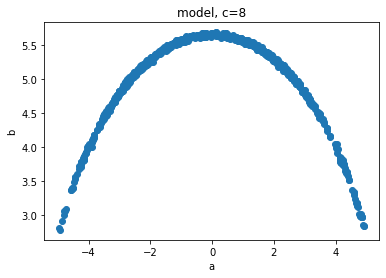

loss @ 0 8.335342347621918
loss @ 200 3.0050434321165085
loss @ 400 2.4098155796527863
loss @ 600 4.404178477823734
loss @ 800 2.4000042974948883
loss @ 1000 2.9277283251285553
loss @ 1200 3.5824536979198456
loss @ 1400 3.2533727139234543
loss @ 1600 4.773899152874947
loss @ 1800 2.32267926633358
loss @ 2000 2.7319775074720383
loss @ 2200 2.707302540540695
loss @ 2400 3.370680585503578
loss @ 2600 2.5268832817673683
loss @ 2800 2.818960815668106
loss @ 3000 3.3527978360652924
loss @ 3200 4.0485124588012695
loss @ 3400 2.290671393275261
loss @ 3600 2.6041832119226456
loss @ 3800 2.875362604856491
loss @ 4000 2.9968242198228836
loss @ 4200 3.1856701970100403
loss @ 4400 2.5905151963233948
loss @ 4600 2.2067520543932915
loss @ 4800 3.4365132823586464
loss @ 5000 3.472474902868271
loss @ 5200 2.348926991224289
loss @ 5400 3.963834598660469
loss @ 5600 2.589806765317917
loss @ 5800 2.37254598736763
loss @ 6000 3.2188163101673126
loss @ 6200 2.315869629383087
loss @ 6400 2.978312686085701
lo

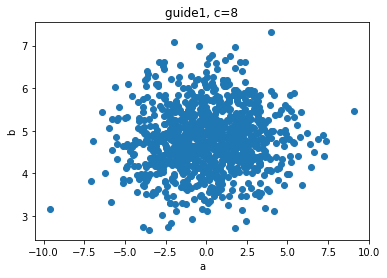

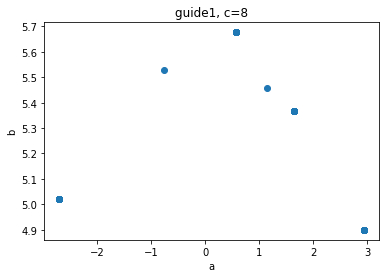

loss @ 0 12.650449186563492
loss @ 200 3.2776109874248505
loss @ 400 3.082300677895546
loss @ 600 2.6618577390909195
loss @ 800 2.84593016654253
loss @ 1000 2.9515788853168488
loss @ 1200 2.829006001353264
loss @ 1400 3.5085834860801697
loss @ 1600 2.8770370334386826
loss @ 1800 3.0869398713111877
loss @ 2000 2.4454394951462746
loss @ 2200 2.068431928753853
loss @ 2400 2.7381143793463707
loss @ 2600 2.8083261847496033
loss @ 2800 2.1782779544591904
loss @ 3000 2.618351072072983
loss @ 3200 1.8330068085342646
loss @ 3400 3.3368087857961655
loss @ 3600 1.9220764599740505
loss @ 3800 2.6583488062024117
loss @ 4000 2.9927460998296738
loss @ 4200 1.6901200823485851
loss @ 4400 2.7797777326777577
loss @ 4600 4.242953859269619
loss @ 4800 2.4056900404393673
loss @ 5000 2.532863959670067
loss @ 5200 2.622054785490036
loss @ 5400 2.8587060421705246
loss @ 5600 2.1531943287700415
loss @ 5800 3.1914183646440506
loss @ 6000 3.232803910970688
loss @ 6200 2.625737078487873
loss @ 6400 2.311864705756

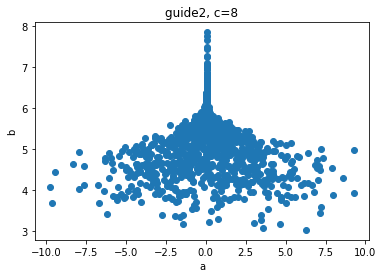

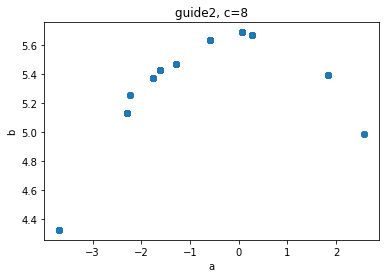

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyro
import torch
import torch.nn as nn
import torch.nn.functional as F

import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.optim
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceGraph_ELBO, MCMC, NUTS

def make_plot(x, y, main):
    plt.plot(x, y, "o")
    plt.title(main)
    plt.xlabel("a")
    plt.ylabel("b")
    plt.show()
    
class simpleNN(nn.Module):
    def __init__(self, input_size=1, hidden=32, out_size=1, t="normal", out_non_linear=None):
        super().__init__()
        self.t = t
        self.out_non_linear = out_non_linear
        self.hiddeen_layer = nn.Linear(input_size, hidden)
        if t == "normal" or t == "gamma":
            self.loc_layer = nn.Linear(hidden, out_size)
            self.std_layer = nn.Linear(hidden, out_size)
            self.softplus = nn.Softplus()
        elif t == "bern":
            self.prob_layer = nn.Linear(hidden, out_size)
        elif t == "mlp":
            self.out_layer = nn.Linear(hidden, out_size)
        
    def forward(self, x_list):
        for i in range(len(x_list)):
            if x_list[i].dim() == 0:
                x_list[i] = torch.unsqueeze(x_list[i], dim=0)
        input_x = torch.cat(x_list, 0)
        hid = F.relu(self.hiddeen_layer(input_x))
        # return loc, std
        if self.t == "normal":
            return self.loc_layer(hid), self.softplus(self.std_layer(hid))
        elif self.t == "gamma":
            return self.softplus(self.loc_layer(hid)), self.softplus(self.std_layer(hid))
        elif self.t == "bern":
            return torch.sigmoid(self.prob_layer(hid))
        else:
            if self.out_non_linear == "tanh":
                return torch.tanh(self.out_layer(hid))
            else:
                return self.out_layer(hid)
    
g1_nnb_c = simpleNN(t="gamma")
g1_nna_c = simpleNN()
g2_nnb_c = simpleNN(t="gamma")
g2_nna_c = simpleNN(input_size=2)

guide1_a = []
guide1_b = []
guide2_a = []
guide2_b = []
    
def model(observations={"c" : 0}):
    a = pyro.sample("a", dist.Normal(0, 2))
    b = pyro.sample("b", dist.Gamma(8, 2))
    c = pyro.sample("c", dist.Normal(a*a / 4 + b*b / 4, 0.05), obs=observations["c"])
    return c
    #return {"a" : a, "b" : b, "c" : c}

def guide1(observations={"c" : 0}):
    pyro.module("g1_nnb_c", g1_nnb_c)
    pyro.module("g1_nna_c", g1_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g1_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g1_nna_c([c])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide1_a.append(a.detach().numpy())
#     guide1_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()

def guide2(observations={"c" : 0}):
    pyro.module("g2_nnb_c", g2_nnb_c)
    pyro.module("g2_nna_c", g2_nna_c)
    c = observations["c"]
    b_alpha, b_beta = g2_nnb_c([c])
    b = pyro.sample("b", dist.Gamma(b_alpha, b_beta))
    a_mu, a_sig = g2_nna_c([c, b])
    a = pyro.sample("a", dist.Normal(a_mu, a_sig))
#     guide2_a.append(a.detach().numpy())
#     guide2_b.append(b.detach().numpy())
    return a.detach().numpy(), b.detach().numpy()
    
c = torch.tensor(8.)
num_samples = 1000

nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_samples=num_samples)
mcmc.run({"c": c})
model_samples = mcmc.get_samples()
model_a = model_samples["a"].detach().numpy()
model_b = model_samples["b"].detach().numpy()
make_plot(model_a, model_b, main="model, c="+str(int(c)))

def run_guide_csis(guide):
    pyro.clear_param_store()
    g1_nnb_c = simpleNN()
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN()
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 10000
    csis = pyro.infer.CSIS(model, guide, optimizer, num_inference_samples=100)

    for step in range(n_steps):
        loss = csis.step()
        if step % 200 == 0:
            print("loss @ " + str(step), loss)
    posterior = csis.run(observations={"c": c})
    marginal = pyro.infer.EmpiricalMarginal(posterior, ["a", "b"])
    csis_samples_a = []
    csis_samples_b = []
    for _ in range(num_samples):
        sample = marginal()
        a = float(sample[0])
        b = float(sample[1])
        csis_samples_a.append(a)
        csis_samples_b.append(b)
    return csis_samples_a, csis_samples_b

guide1_a_is, guide1_b_is = run_guide_csis(guide1)
for _ in range(num_samples):
    a, b =guide1({"c" : c})
    guide1_a.append(a)
    guide1_b.append(b)
make_plot(guide1_a, guide1_b, main="guide1, c="+str(int(c)))
make_plot(guide1_a_is, guide1_b_is, main="guide1, c="+str(int(c)))

guide2_a_is, guide2_b_is = run_guide_csis(guide2)
for _ in range(num_samples):
    a, b =guide2({"c" : c})
    guide2_a.append(a)
    guide2_b.append(b)
make_plot(guide2_a, guide2_b, main="guide2, c="+str(int(c)))
make_plot(guide2_a_is, guide2_b_is, main="guide2, c="+str(int(c)))

'''
def run_guide_svi(guide):
    pyro.clear_param_store()
    g1_nnb_c = simpleNN()
    g1_nna_c = simpleNN()
    g2_nnb_c = simpleNN()
    g2_nna_c = simpleNN(input_size=2)
    adam_params = {"lr": 0.005, "betas": (0.95, 0.999)}
    optimizer = Adam(adam_params)
    n_steps = 5000
    guide_a = []
    guide_b = []
    svi = SVI(model, guide, optimizer, loss=Trace_ELBO())
    for step in range(n_steps):
        loss = svi.step({"c" : c})
        if step % 100 == 0:
            print("loss @ " + str(step), loss)
    for _ in range(num_samples):
        a, b =guide({"c" : c})
        guide_a.append(a)
        guide_b.append(b)
    return guide_a, guide_b
# guide1_a, guide1_b = run_guide_svi(guide1)
# make_plot(guide1_a, guide1_b, main="guide1")
# guide2_a, guide2_b = run_guide_svi(guide2)
# make_plot(guide2_a, guide2_b, main="guide2")
'''